In [77]:
import os
import cv2
from ultralytics import YOLO
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import sys

# Load YOLO model
model = YOLO('./best.pt')

# Input and output directories
input_dir = 'dataset'
output_dir = 'output'
custom_label = 'detected_object'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

id 0 -> 0 degree
id 125 -> 360 degree

In [78]:
def get_degree(id, shift=0):
    d = (id + shift)/125 * 360
    while d > 360:
        d -= 360
    if d < 0:
        d += 360
    return int(d)

In [79]:
for i in range(360):
    out = os.path.join(output_dir, f"{i}")
    os.makedirs(out, exist_ok=True)

In [80]:
for subfolder in ['1x', '2x']:
    subfolder_path = os.path.join(input_dir, subfolder)
    image_names = sorted(os.listdir(subfolder_path))
    print(f"There are {len(image_names)} images in {subfolder_path}")

    for i, image_name in tqdm(enumerate(image_names), total=len(image_names)):
        image_path = os.path.join(subfolder_path, image_name)
        # Sort the image names to ensure sequential loading
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        w,h = image.shape[1], image.shape[0]
        if subfolder == '1x':
            # Crop to center
            crop = 160
            image = image[h//2-crop:h//2+crop, w//2-crop:w//2+crop]
            degree = get_degree(i, shift=0)
        elif subfolder == '2x':
            shift = 150
            image = image[h//2-320+shift:h//2+320+shift, w//2-320:w//2+320]
            degree = get_degree(i, shift = -27)
        
        # Run YOLO model on the image

        results = model(image, verbose=False, device='cpu')
        detections = results[0]  # Extract detections
        
        # Process each detection
        for i, det in enumerate(detections):
            x1, y1, x2, y2 = det.boxes.xyxy[0].tolist()
            conf = det.boxes.conf[0].item()
            if conf < 0.7:  # Confidence threshold
                continue
            
            # Crop the detected region
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            cropped = image[y1:y2, x1:x2]
            
            # Save the cropped image with custom label
            output_path = os.path.join(output_dir, f"{degree}", image_name)
            cv2.imwrite(output_path, cropped)

There are 180 images in dataset/1x


100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


There are 180 images in dataset/2x


100%|██████████| 180/180 [00:20<00:00,  9.00it/s]


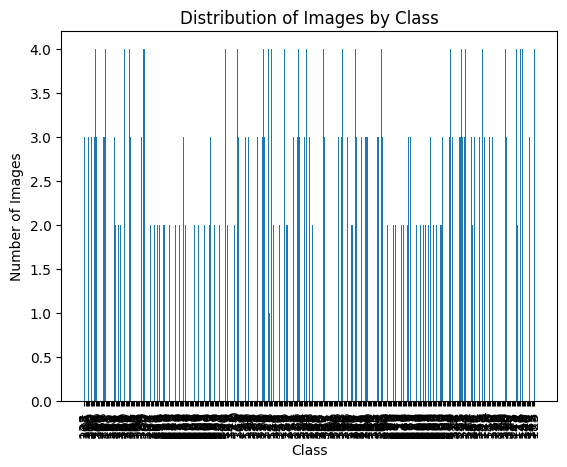

In [81]:
from collections import Counter

# Get the list of subfolders (classes) in the output directory
classes = [folder for folder in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, folder))]

# Count the number of images in each class
class_counts = {cls: len(os.listdir(os.path.join(output_dir, cls))) for cls in classes}

# Plot the histogram
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Class')
plt.xticks(rotation=90)
plt.show()